In [1]:
from PIL import Image
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

from filters import KalmanFilter

def get_img_number(img_filepath):
    return int(os.path.basename(img_filepath).split('.')[0])

bg_path = './source/10.TrackKalman/Img/bg.jpg'
img_paths = sorted(glob('./source/10.TrackKalman/Img/[0-9]*.jpg'), key=get_img_number)
img_paths

['./source/10.TrackKalman/Img/1.jpg',
 './source/10.TrackKalman/Img/2.jpg',
 './source/10.TrackKalman/Img/3.jpg',
 './source/10.TrackKalman/Img/4.jpg',
 './source/10.TrackKalman/Img/5.jpg',
 './source/10.TrackKalman/Img/6.jpg',
 './source/10.TrackKalman/Img/7.jpg',
 './source/10.TrackKalman/Img/8.jpg',
 './source/10.TrackKalman/Img/9.jpg',
 './source/10.TrackKalman/Img/10.jpg',
 './source/10.TrackKalman/Img/11.jpg',
 './source/10.TrackKalman/Img/12.jpg',
 './source/10.TrackKalman/Img/13.jpg',
 './source/10.TrackKalman/Img/14.jpg',
 './source/10.TrackKalman/Img/15.jpg',
 './source/10.TrackKalman/Img/16.jpg',
 './source/10.TrackKalman/Img/17.jpg',
 './source/10.TrackKalman/Img/18.jpg',
 './source/10.TrackKalman/Img/19.jpg',
 './source/10.TrackKalman/Img/20.jpg',
 './source/10.TrackKalman/Img/21.jpg',
 './source/10.TrackKalman/Img/22.jpg',
 './source/10.TrackKalman/Img/23.jpg',
 './source/10.TrackKalman/Img/24.jpg']

In [2]:
def get_ball_pos(img):
    h, w, _ = img.shape
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    nx, ny = np.random.normal(0, 15, 2)
    fg = img.mean(axis=2) < 200
    fgx = xs[fg] + nx
    fgy = ys[fg] + ny
    
    left = fgx.min()
    right = fgx.max()
    top = fgy.min()
    bottom = fgy.max()
    return int((left+right) / 2), int((top+bottom) / 2)
    
imgs = [np.array(Image.open(p)) for p in img_paths]
ball_positions = [get_ball_pos(i) for i in imgs]

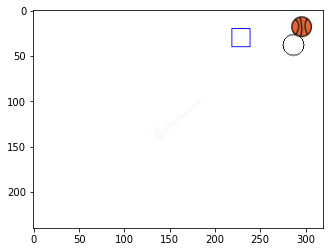

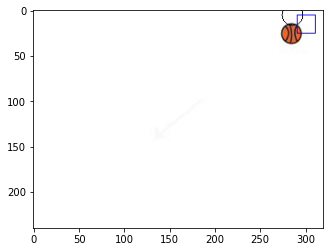

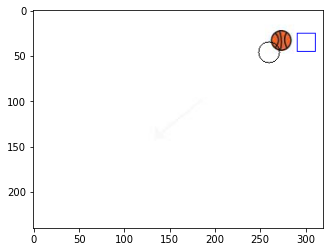

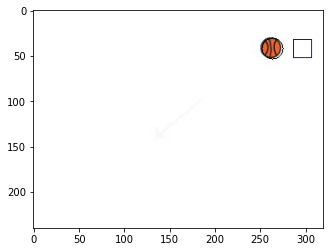

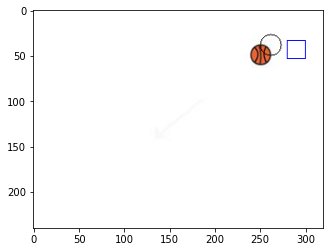

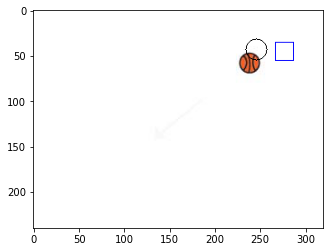

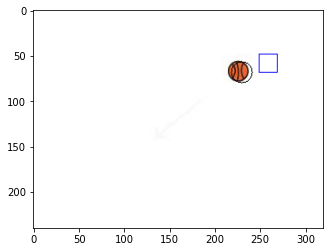

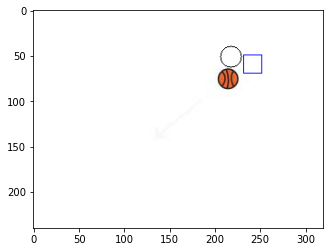

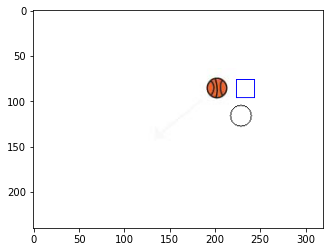

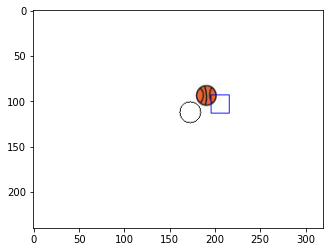

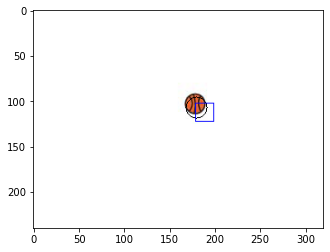

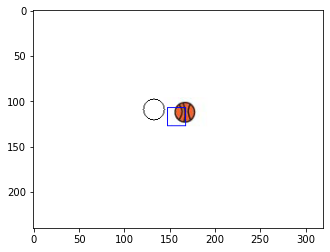

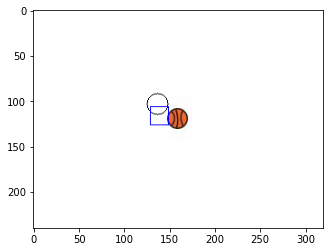

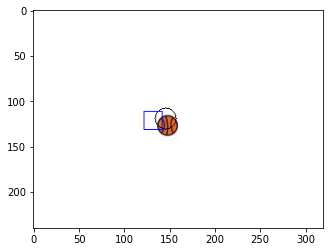

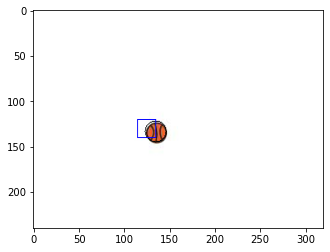

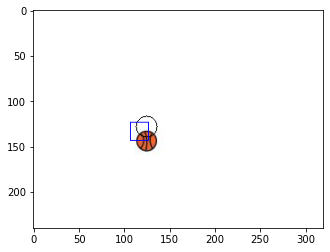

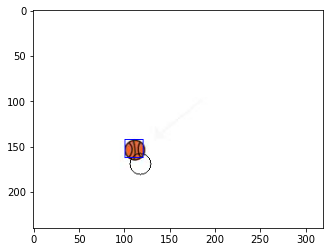

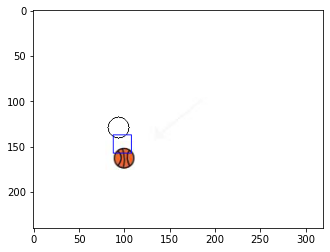

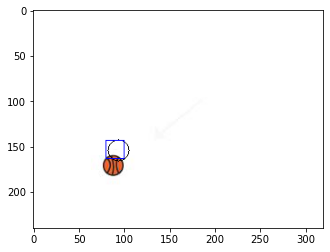

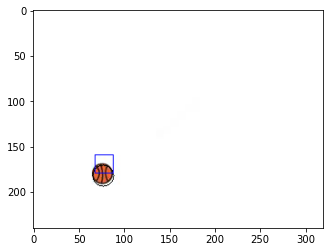

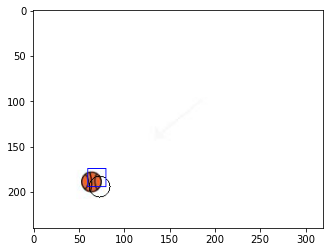

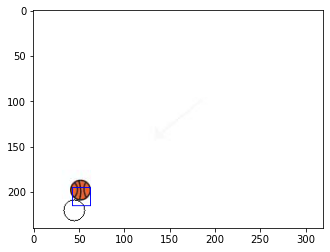

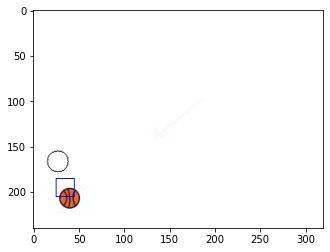

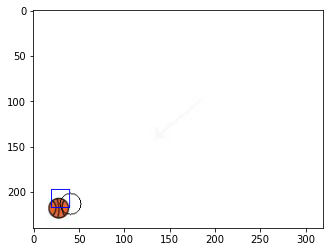

In [3]:
dt = 1
ts = np.arange(len(imgs)) * dt
kf = KalmanFilter(
    x0 = np.array([[0, 0, 0, 0]]).T,
    P0 = 100 * np.eye(4),
    A = np.array([
        [1, dt, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, dt],
        [0, 0, 0, 1],
    ]),
    H = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0],
    ]),
    Q = np.eye(4),
    R = np.array([
        [50, 0],
        [0, 50],
    ]))

predictions = []

for t, pos, img in zip(ts, ball_positions, imgs):
    x_meas, y_meas = pos
    kf.update(np.array(pos).reshape(2, 1))
    
    pos_pred = kf.get()
    x_pred = int(pos_pred[0, 0])
    y_pred = int(pos_pred[1, 0])
    predictions.append((x_pred, y_pred))
    
    sq_lt = (x_pred-10, y_pred-10)
    sq_rb = (x_pred+10, y_pred+10)
    
    img = cv2.circle(img, pos, 12, (0, 0, 0), 1)
    img = cv2.rectangle(img, sq_lt, sq_rb, (0, 0, 255), 1)
    
    
    plt.imshow(img)
    plt.show()


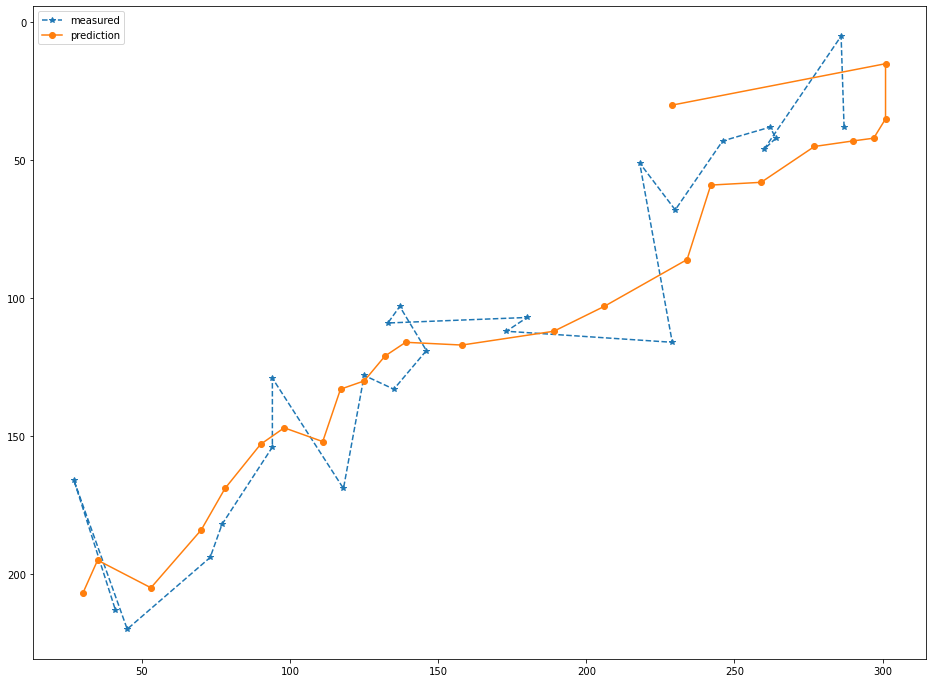

In [4]:
meas_x, meas_y = zip(*ball_positions)
pred_x, pred_y = zip(*predictions)
fig = plt.figure(figsize=[16, 12])
plt.gca().invert_yaxis()
plt.plot(meas_x, meas_y, '*--', label="measured")
plt.plot(pred_x, pred_y, 'o-', label="prediction")
plt.legend()
plt.show()

In [5]:
kf2 = KalmanFilter(
    x0 = np.array([[0, 0, 0, 0]]).T,
    P0 = 100 * np.eye(4),
    A = np.array([
        [1, dt, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, dt],
        [0, 0, 0, 1],
    ]),
    H = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0],
    ]),
    Q = np.eye(4) / 100,
    R = np.array([
        [50, 0],
        [0, 50],
    ]))

predictions2 = []

for t, pos, img in zip(ts, ball_positions, imgs):
    x_meas, y_meas = pos
    kf2.update(np.array(pos).reshape(2, 1))
    
    pos_pred = kf2.get()
    x_pred = int(pos_pred[0, 0])
    y_pred = int(pos_pred[1, 0])
    predictions2.append((x_pred, y_pred))

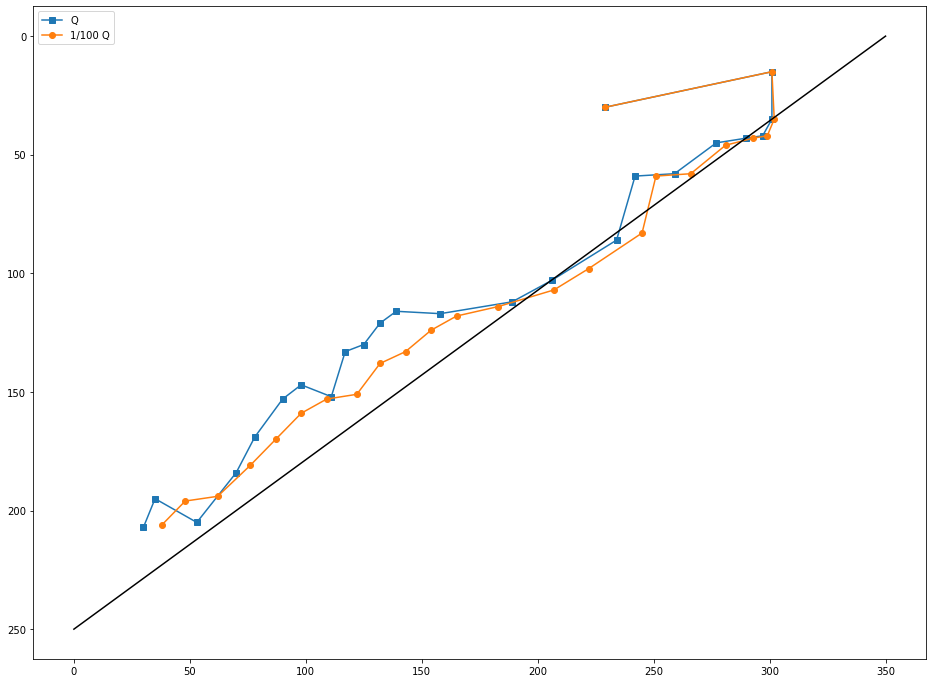

In [6]:
pred2_x, pred2_y = zip(*predictions2)
fig = plt.figure(figsize=[16, 12])
plt.gca().invert_yaxis()
plt.plot(pred_x, pred_y, 's-', label="Q")
plt.plot(pred2_x, pred2_y, 'o-', label="1/100 Q")
plt.plot(np.linspace(0, 350, 2), np.linspace(250, 0, 2), color='black')
plt.legend()
plt.show()